<a href="https://colab.research.google.com/github/jenny12138/Facial_Expression_Emoji/blob/main/EmotionClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Set-Up and Pre-Processing
1) Mount drive to this notebook.

2) Import the necessary libraries for this project.

3) Load trainining data (From Kaggle: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/notebooks)

4) Set up X_train, y_train, X_test, and y_test

In [1]:
#Mount Google Drive to this notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import csv
import sys
import numpy as np
import random
import pandas as pd
from sklearn import preprocessing
import collections
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split 
from PIL import Image
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import metrics
import random
from tensorflow import keras
import os
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
#Loading our training and validation data using csv_reader
#Training data taken from https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/notebooks (train.csv file)
with open('/content/drive/My Drive/Data/train.csv') as csv_file:
  csv_reader = csv.reader(csv_file)
  train_colnames = next(csv_reader) #The column names, 'emotion' and 'pixels', are stored in the list colnames
  train_data = list(csv_reader) #Holds all the data, with each row as a list within the list variable data, has 28709 items

In [ ]:
X_train = [item[1].split() for item in train_data] #Vectorized each X_train sample, 28709 samples, 2304 pixels each
X_train = np.array(X_train)
X_train = X_train.astype(int)

y_train = [item [0] for item in train_data] #All the y_train data is stored in one vector, 28709 samples
y_train = np.array(y_train)
y_train = y_train.astype(int)

In [ ]:
collections.Counter(y_train)

Counter({0: 3995, 1: 436, 2: 4097, 3: 7215, 4: 4830, 5: 3171, 6: 4965})

In [ ]:
#Transform y so that Angry == disgust, and fear == surprise (since these expressions are so similar)
y_over = np.where(y_train==1, 0, y_train)
y_over = np.where(y_over==5, 2, y_over)

#Rearrange numbers in y so that 0=Angry/disgust, 1=Neutral, 2=Fear/Surprise, 3=Happy, 4=Sad
y_over = np.where(y_over==6, 1, y_over)
y_train = y_over
collections.Counter(y_train)

Counter({0: 4431, 1: 4965, 2: 7268, 3: 7215, 4: 4830})

In [ ]:
#The dataset is not balanced. To account for the bias in the dataset, we will use oversampling
ros = RandomOverSampler(sampling_strategy='auto')
X_over, y_over = ros.fit_resample(X_train, y_train)
collections.Counter(y_over)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 7268, 1: 7268, 2: 7268, 3: 7268, 4: 7268})

In [ ]:
#There are 7 output categories. Apply one-hot-encoding to convert each y label into a R^7 vector
lb = preprocessing.LabelBinarizer()
y_over_vectorized=lb.fit_transform(y_over) #Applying one-hot-encoding to original labels

In [ ]:
#Divide our training data and validation data 70%-30%
X_train,X_val,y_train,y_val = train_test_split(X_over,y_over_vectorized, test_size=0.3)

#Check that we have divided our training data and validation data properly
print(type(X_train))
print(type(y_train))
print(type(X_val))
print(type(y_val))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(y_val.shape))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
X_train shape: (25438, 2304)
Y_train shape: (25438, 5)
X_val shape: (10902, 2304)
Y_val shape: (10902, 5)


In [ ]:
#Our model will take in dim 4 X inputs. Transform X_train and X_val so that it can be used in our model later.
X_train = X_train.reshape(-1, 48, 48)
X_train = X_train[..., np.newaxis]

X_val = X_val.reshape(-1, 48, 48)
X_val = X_val[..., np.newaxis]


# Part 2: Preview a few pictures from the dataset:


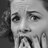

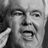

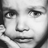

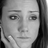

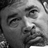

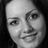

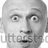

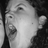

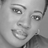

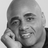

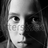

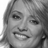

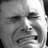

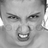

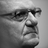

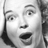

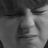

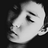

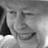

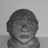

In [ ]:
for i in range(20):
  array = np.asarray(X_train[i])
  array = array.reshape(48, 48)
  array = array.astype(np.uint8)
  display(Image.fromarray(array))

# Part 3: Create Convolutional Neural Network (CNN)

For our CNN model, we will use the deep network architecture consisting of 4 convolutional layers and 2 fully connected layers detailed in this report: http://cs231n.stanford.edu/reports/2016/pdfs/005_Report.pdf

In [ ]:
model = tf.keras.Sequential() #Create a sequential model

#Convolutional layer #1
#Use Conv2D as we are processing image
#64 filters, typical (3,3) kernel used
#Padding set to same to preserve the spatial dimensions of the volume such that the output volume size matches the input volume size
model.add(layers.Conv2D(64, (3, 3), padding="same", input_shape=(48, 48, 1))) #Input size is 48 pixels by 48 pixels, greyscale so 1 color channel
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.MaxPool2D(pool_size=(2,2))) #Max pooling used to reduce the spatial dimensions of the output volume.
model.add(layers.Dropout(0.25)) #Prevents overfitting

#Convolutional layer #2
model.add(layers.Conv2D(128, (3, 3), padding="same")) #Input size is 48 pixels by 48 pixels, greyscale so 1 color channel
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.MaxPool2D(pool_size=(2,2))) #Max pooling used to reduce the spatial dimensions of the output volume.
model.add(layers.Dropout(0.25)) #Prevents overfitting

#Convolutional layer #3
model.add(layers.Conv2D(512, (3, 3), padding="same")) #Input size is 48 pixels by 48 pixels, greyscale so 1 color channel
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.MaxPool2D(pool_size=(2,2))) #Max pooling used to reduce the spatial dimensions of the output volume.
model.add(layers.Dropout(0.25)) #Prevents overfitting

#Convolutional layer #4
model.add(layers.Conv2D(512, (3, 3), padding="same")) #Input size is 48 pixels by 48 pixels, greyscale so 1 color channel
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.MaxPool2D(pool_size=(2,2))) #Max pooling used to reduce the spatial dimensions of the output volume.
model.add(layers.Dropout(0.25)) #Prevents overfitting

#Flatten the volume to pass through fully connected layer
model.add(layers.Flatten())

#Fully connected layer #1
model.add(layers.Dense(256))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.25)) #Prevents overfitting

#Fully connected layer #2
model.add(layers.Dense(512))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.25)) #Prevents overfitting

#Classification result
model.add(layers.Dense(5, activation="softmax"))

#We will use the Adam optimizer, and compile our model
optimizer = Adam(learning_rate=0.0005) #Set learning rate to 0.0005
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Part 4: Train model, then evaluate

In [ ]:
epochs = 5

checkpoint = ModelCheckpoint("model_weights.h5", monitor="val_accuracy", 
                            save_weights_only=True, mode="max", verbose=1)

reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.1, patience=2, min_lr=0.00001, model="auto") #learning rate scheduling, decreases learning rate by 0.1 if doesn't get better for 2 epochs

callbacks = [checkpoint, reduce_lr]

history = model.fit(
    x = X_train,
    y = y_train,
    validation_data = (X_val, y_val),
    epochs=epochs,
    callbacks = callbacks
    )

Epoch 1/5
795/795 [==============================] - ETA: 0s - loss: 0.2636 - accuracy: 0.9063
Epoch 00001: saving model to model_weights.h5
795/795 [==============================] - 15s 19ms/step - loss: 0.2636 - accuracy: 0.9063 - val_loss: 0.9745 - val_accuracy: 0.7460
Epoch 2/5
793/795 [============================>.] - ETA: 0s - loss: 0.2473 - accuracy: 0.9109
Epoch 00002: saving model to model_weights.h5
795/795 [==============================] - 15s 19ms/step - loss: 0.2473 - accuracy: 0.9109 - val_loss: 1.1316 - val_accuracy: 0.7306
Epoch 3/5
795/795 [==============================] - ETA: 0s - loss: 0.2347 - accuracy: 0.9137
Epoch 00003: saving model to model_weights.h5
795/795 [==============================] - 15s 19ms/step - loss: 0.2347 - accuracy: 0.9137 - val_loss: 1.1148 - val_accuracy: 0.7363
Epoch 4/5
794/795 [============================>.] - ETA: 0s - loss: 0.2202 - accuracy: 0.9215
Epoch 00004: saving model to model_weights.h5
795/795 [============================

In [ ]:
# Evaluate the model on the test data using model.evaluate
print("Evaluate on validation data")
results = model.evaluate(X_val, y_val)
print("val loss, val acc:", results)

Evaluate on validation data
341/341 [==============================] - 2s 6ms/step - loss: 1.1638 - accuracy: 0.7349
val loss, val acc: [1.163813829421997, 0.7349110245704651]


In [ ]:
from datetime import datetime

#Save my model to my Google Drive
now = datetime.now()
dt_string = now.strftime("%d.%m.%Y.%H.%M.%S")
model.save("/content/drive/My Drive/my_model.{}".format(dt_string))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/my_model.26.11.2020.02.51.17/assets


In [3]:
reconstructed_model = keras.models.load_model("/content/drive/My Drive/my_model.26.11.2020.02.51.17")

In [ ]:
#Test to make sure that my model was reconstructed successfully
print("Evaluate on validation data")
results = reconstructed_model.evaluate(X_val, y_val)
print("val loss, val acc:", results)

Evaluate on validation data
341/341 [==============================] - 2s 6ms/step - loss: 1.1638 - accuracy: 0.7349
val loss, val acc: [1.163813829421997, 0.7349110245704651]


# Part 5: Visualize a few of our predictions

In [4]:
emotions = ["Angry", "Neutral", "Surprise", "Happy", "Sad"]

for i in range(20):
  print("Human-label:")
  rand_index = random.randint(1,1000) #Take a random sample in the test data
  array = X_val[rand_index].reshape(48, 48)
  array = array.astype(np.uint8)
  print(emotions[y_val[rand_index].argmax(axis=-1)]) #Take the index of the 1 value (max since everything else is 0)
  print("Model-generated label:")
  test = X_val[rand_index].reshape(1, 48, 48, 1)
  prediction = reconstructed_model.predict(test)
  y_classes = prediction.argmax(axis=-1)
  y_classes = y_classes.reshape((1,-1))
  y_classes = int(y_classes[0])
  print(emotions[y_classes])
  display(Image.fromarray(array))
  print("")

Human-label:


NameError: ignored

# Part 6: Testing Dataset Using Kaggle Competition Test Cases (Haven't been used in this notebook yet)

In [ ]:
#Use pandas to read the Kaggle competition test set (not used for training or validation in my model)
df = pd.read_csv("/content/drive/My Drive/Data/icml_face_data.csv")
t = df.loc[(df[' Usage'] == "PrivateTest") | (df[' Usage'] == "PublicTest")]
final_test_data = df[['emotion', ' pixels']]
final_test_X = final_test_data[' pixels'].astype(str).values.tolist()
final_test_y = final_test_data['emotion'].astype(str).values.tolist()

In [ ]:
test_X = [item.split() for item in final_test_X] #Vectorized each test_X
test_X = np.array(test_X)
test_X = test_X.astype(int)

In [ ]:
test_X = test_X.reshape(len(test_X), 48, 48)
test_X = test_X[..., np.newaxis]

In [ ]:
test_y = [item.split() for item in final_test_y] #Vectorized each test_y
test_y = np.array(test_y)
test_y = test_y.astype(int)

lb = preprocessing.LabelBinarizer()
test_y_vectorized=lb.fit_transform(test_y) #Applying one-hot-encoding to test_y labels

In [ ]:
print(test_X.shape)
print(test_y_vectorized.shape)

(35887, 48, 48, 1)
(35887, 7)


In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
test_results = reconstructed_model.evaluate(test_X, test_y_vectorized, batch_size=64)
print("test loss, test acc:", test_results)

Evaluate on test data
561/561 [==============================] - 5s 9ms/step - loss: 0.5695 - accuracy: 0.8245
test loss, test acc: [0.5694643259048462, 0.8245325684547424]


# Part 7: Generating Confusion Matrix and accuracy/precision-recall/logistic loss for Test results

In [ ]:
from sklearn.metrics import confusion_matrix
y_test_pred = reconstructed_model.predict(test_X)
y_test_pred= np.argmax(y_test_pred, axis=1)
cfm = confusion_matrix(y_test_true, y_test_pred)
cfm

array([[4171,   24,  140,   57,  206,   94,  261],
       [  22,  505,    3,    4,    5,    4,    4],
       [ 240,    7, 3667,   63,  342,  458,  344],
       [ 203,    8,   79, 7529,  157,  307,  706],
       [ 410,   11,  247,   90, 4540,   64,  715],
       [  29,    8,   38,   27,   23, 3825,   52],
       [ 288,    2,   93,   94,  319,   49, 5353]])

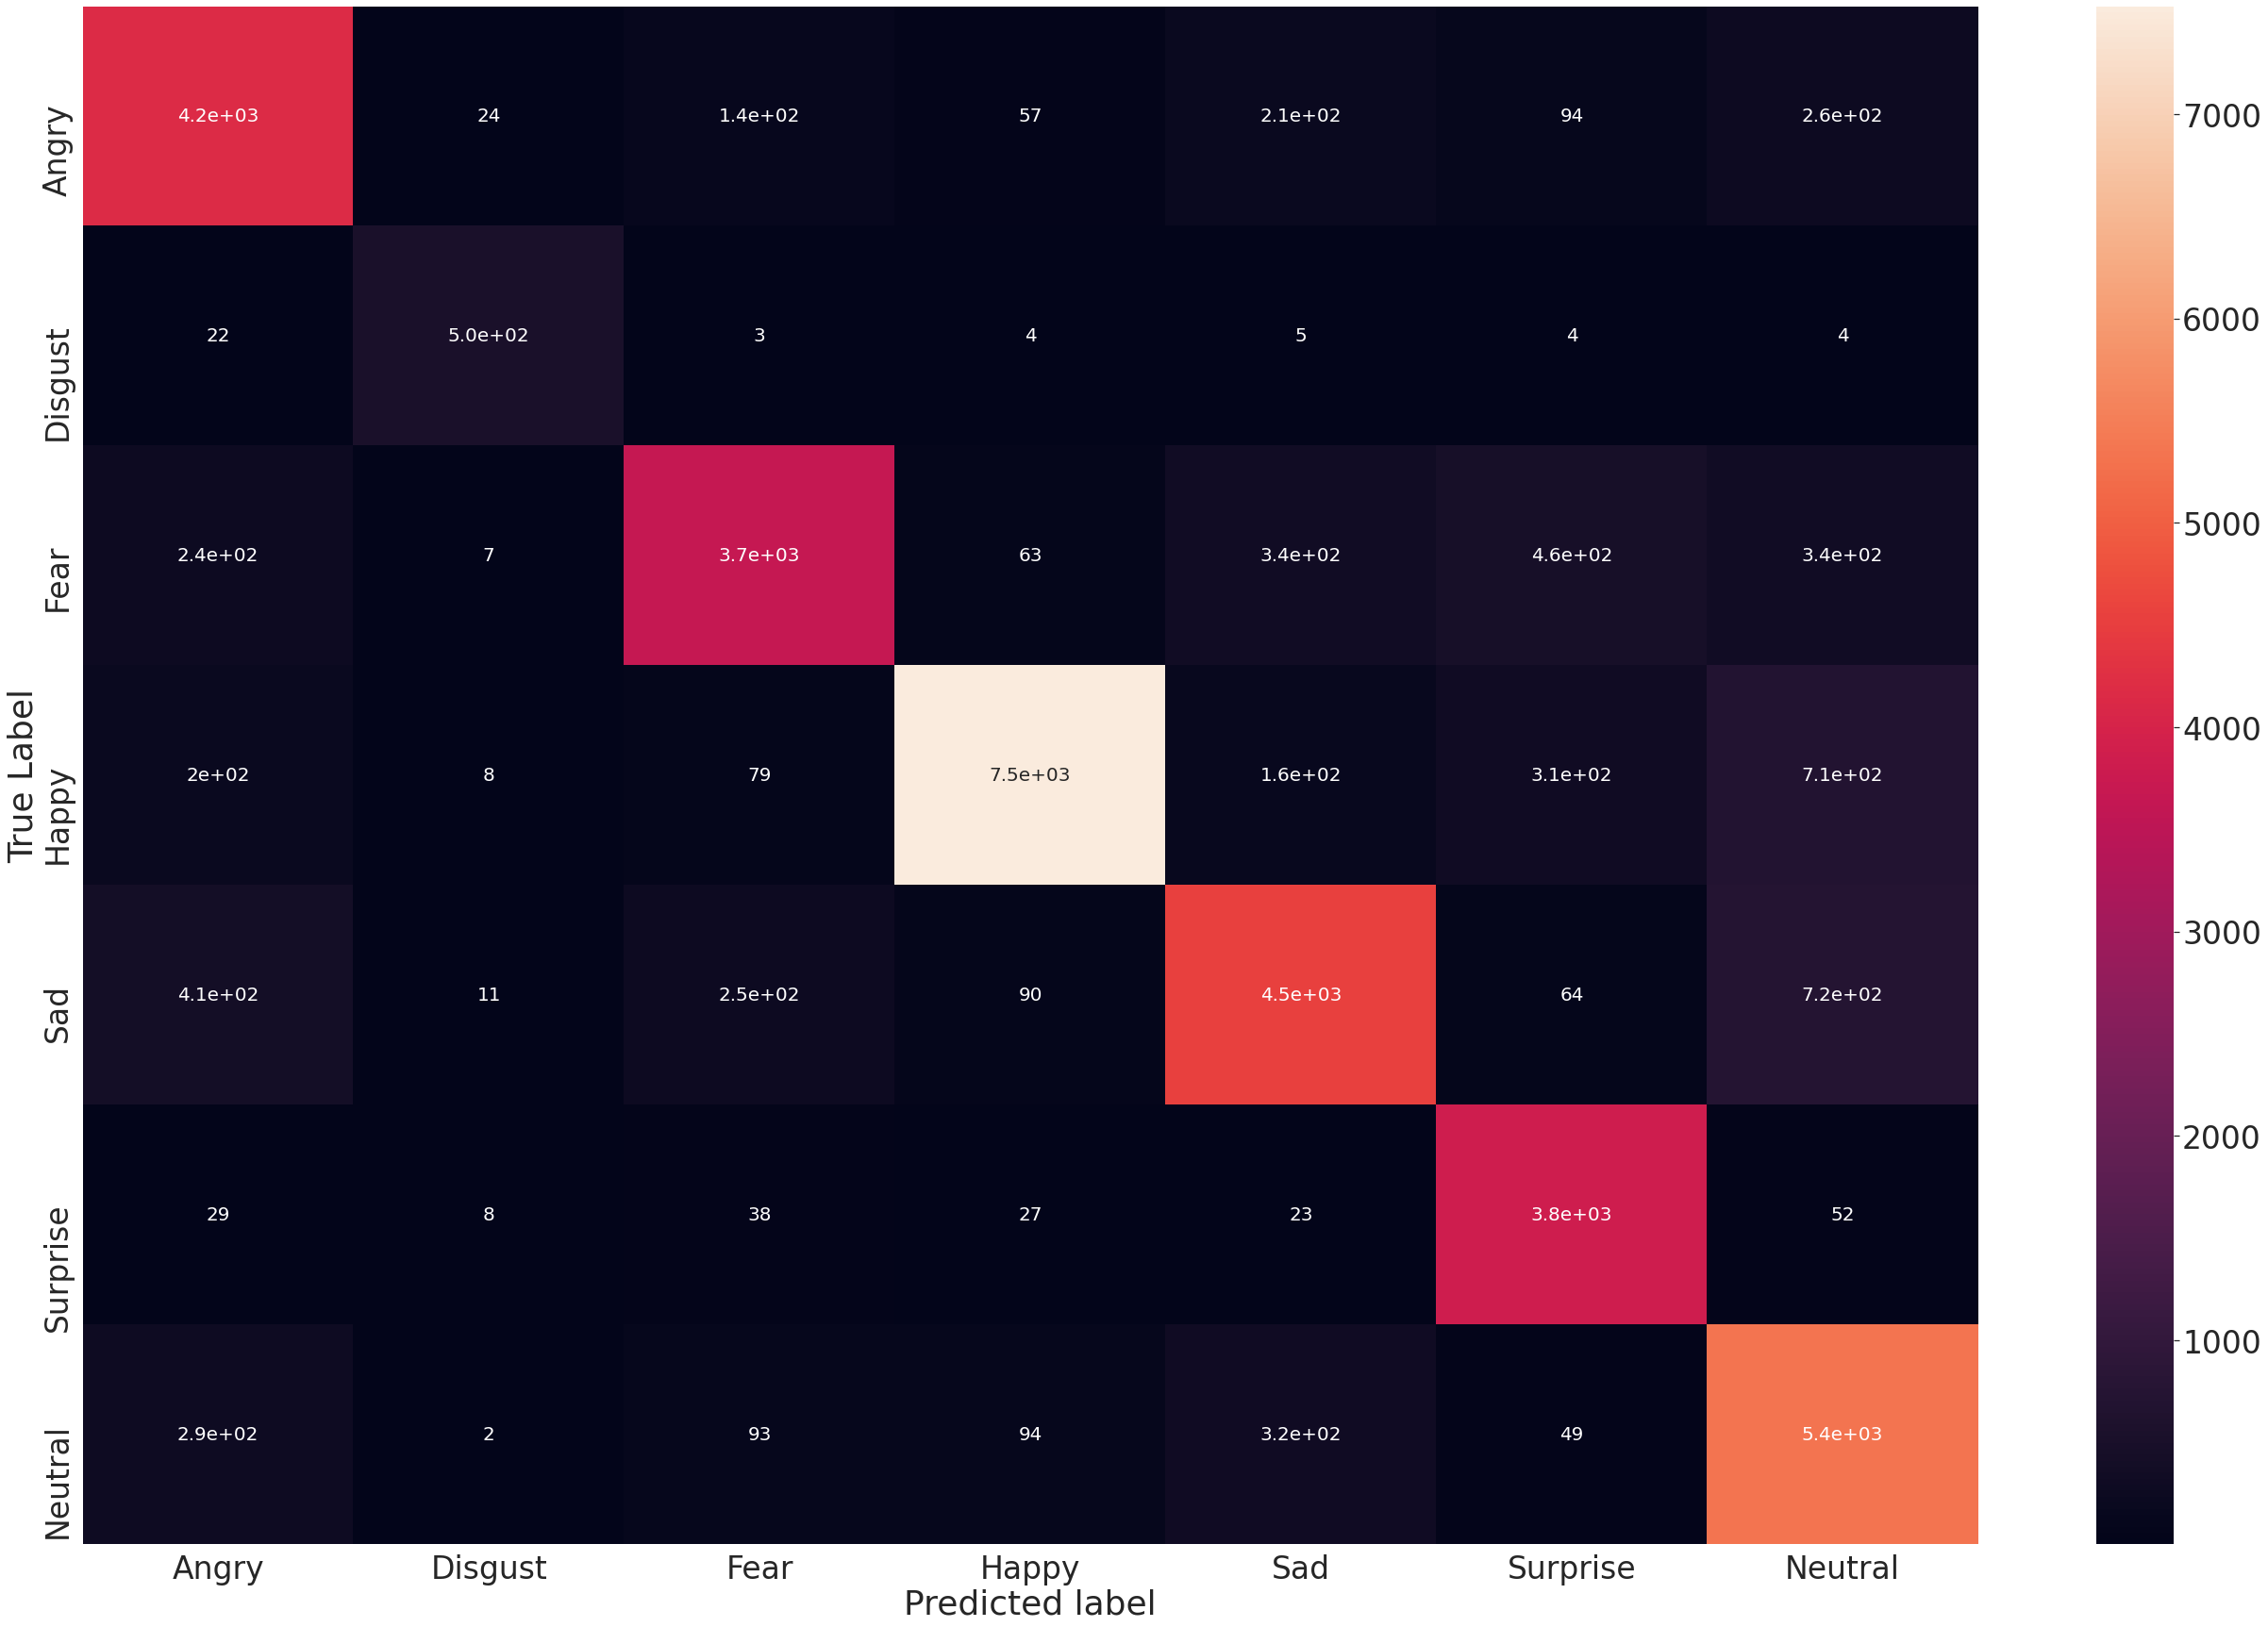

In [ ]:
df_cm = pd.DataFrame(cfm, index=["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"], columns=["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"])
plt.figure(figsize=(45,30))
sn.set(font_scale=3) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 20}) # font size
plt.xlabel("Predicted label")
plt.ylabel("True Label")
plt.show()

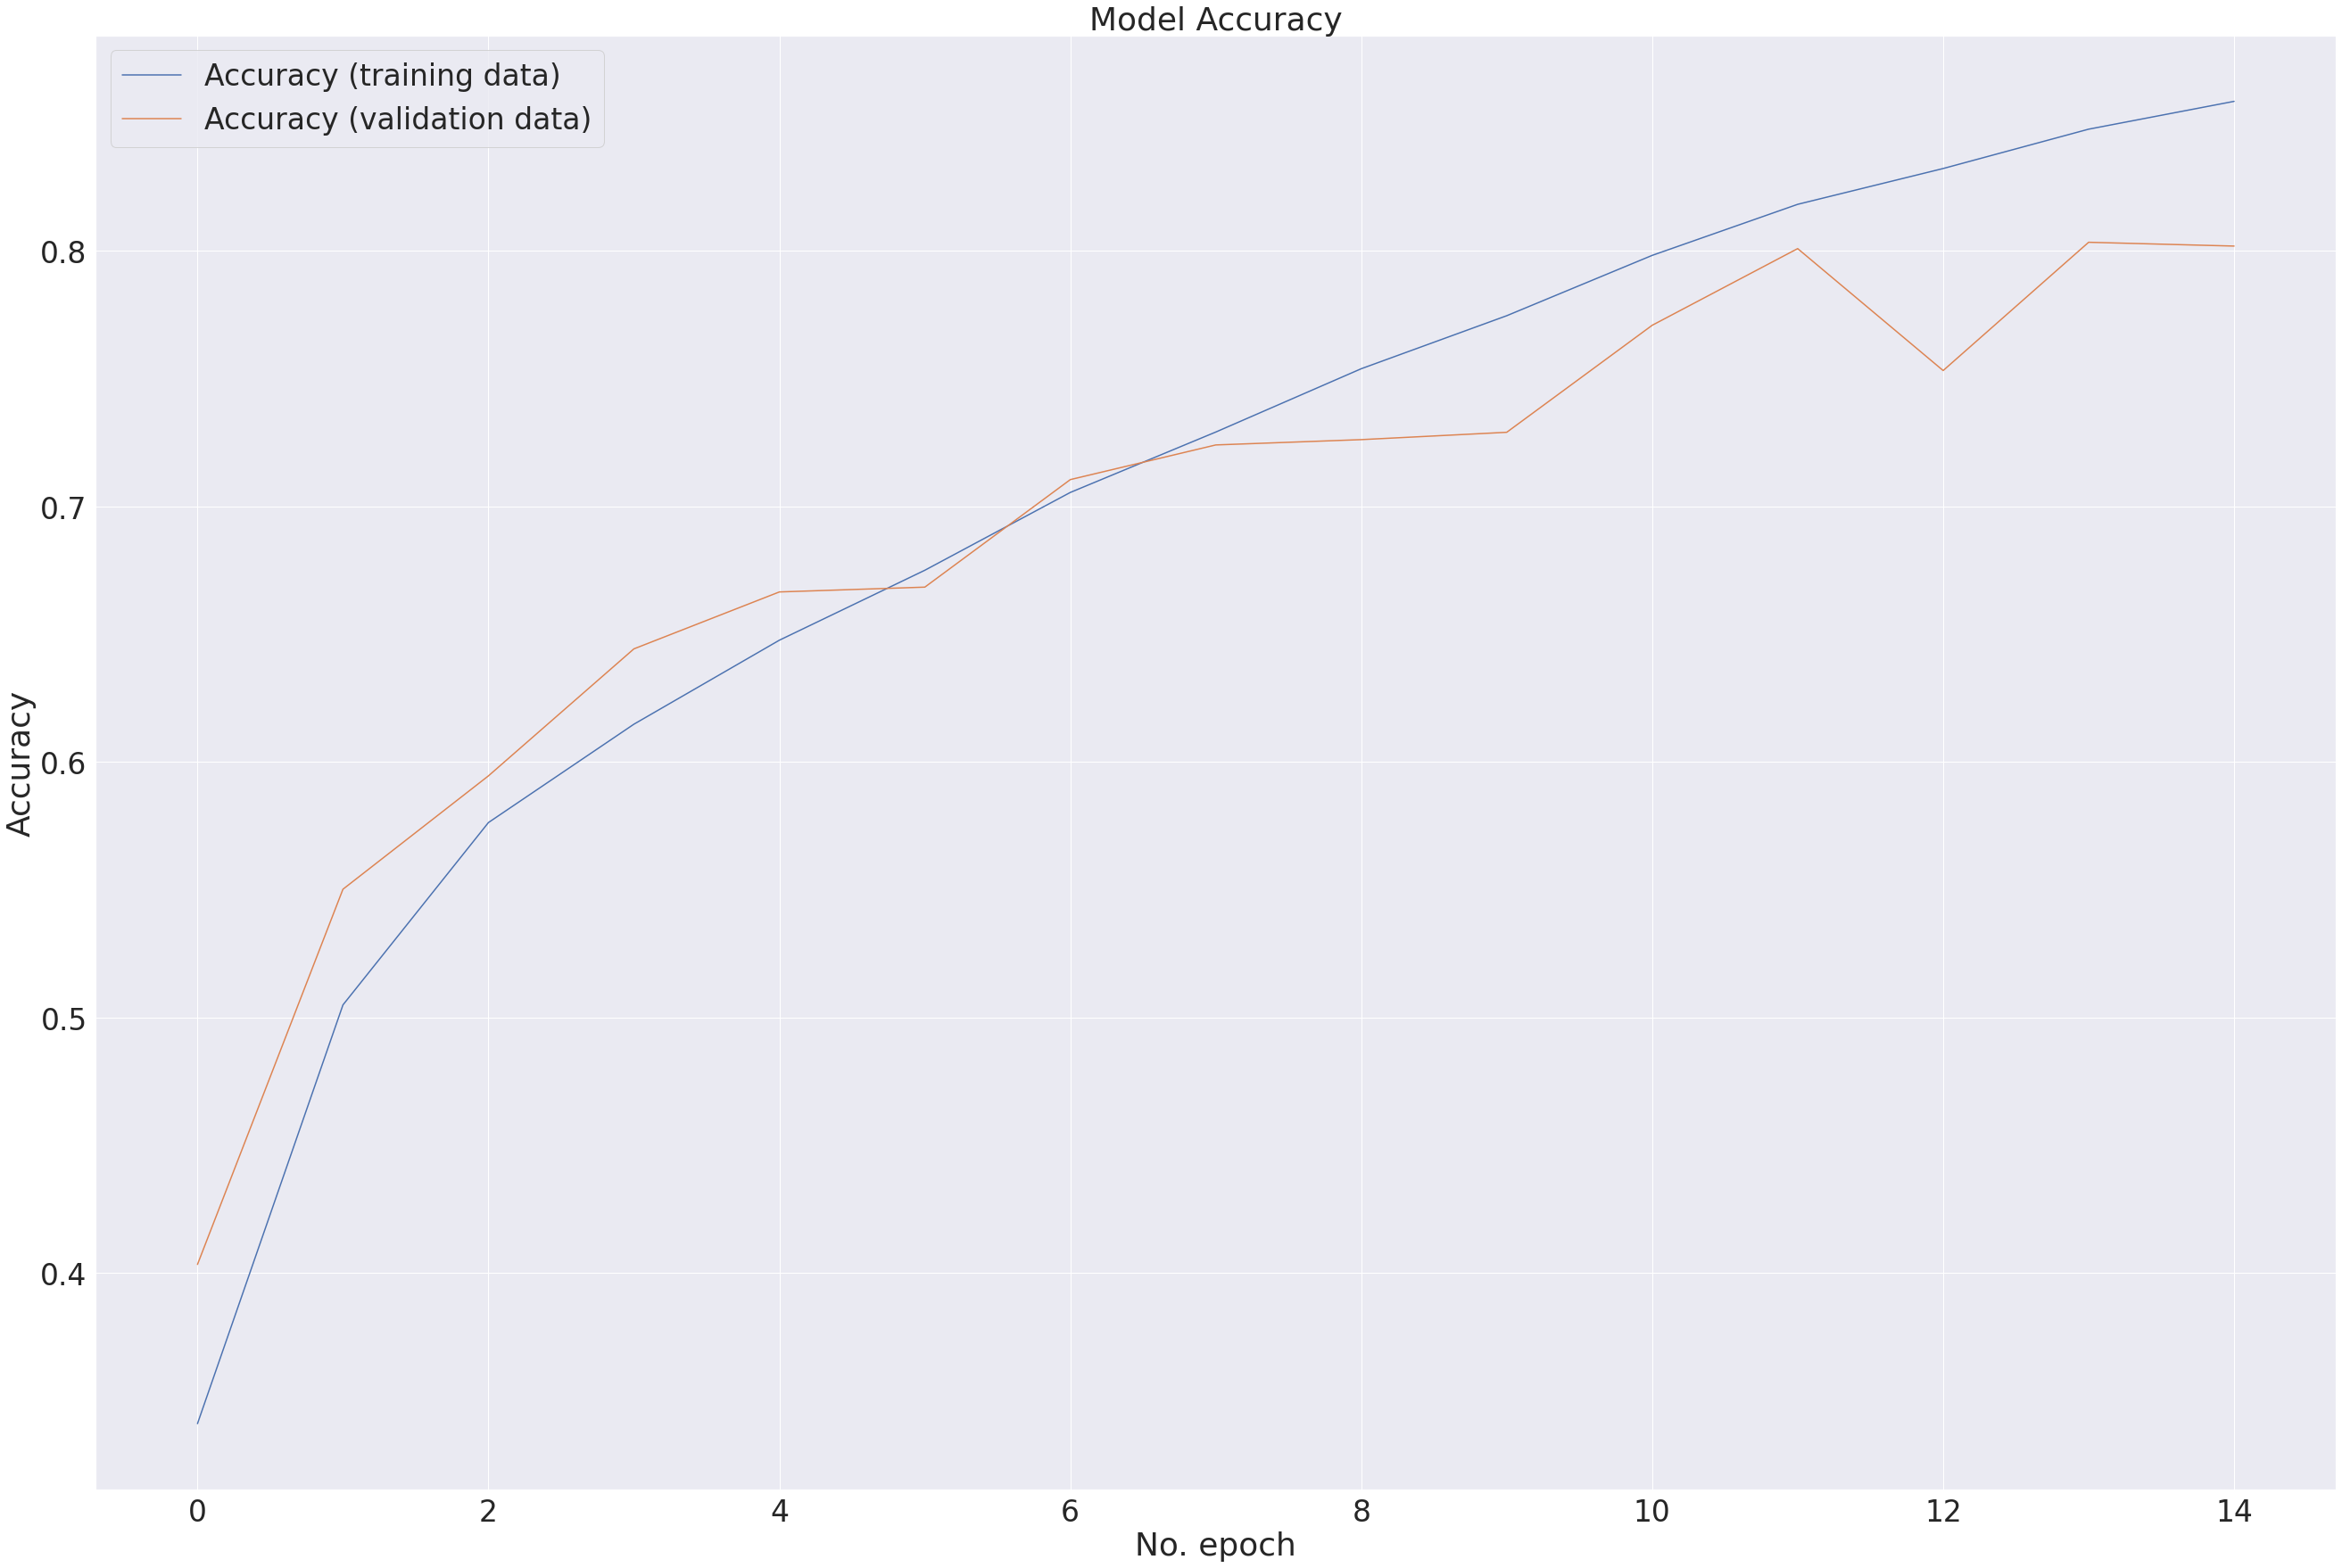

In [ ]:
# Plot history: Accuracy
plt.figure(figsize=(45,30))
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

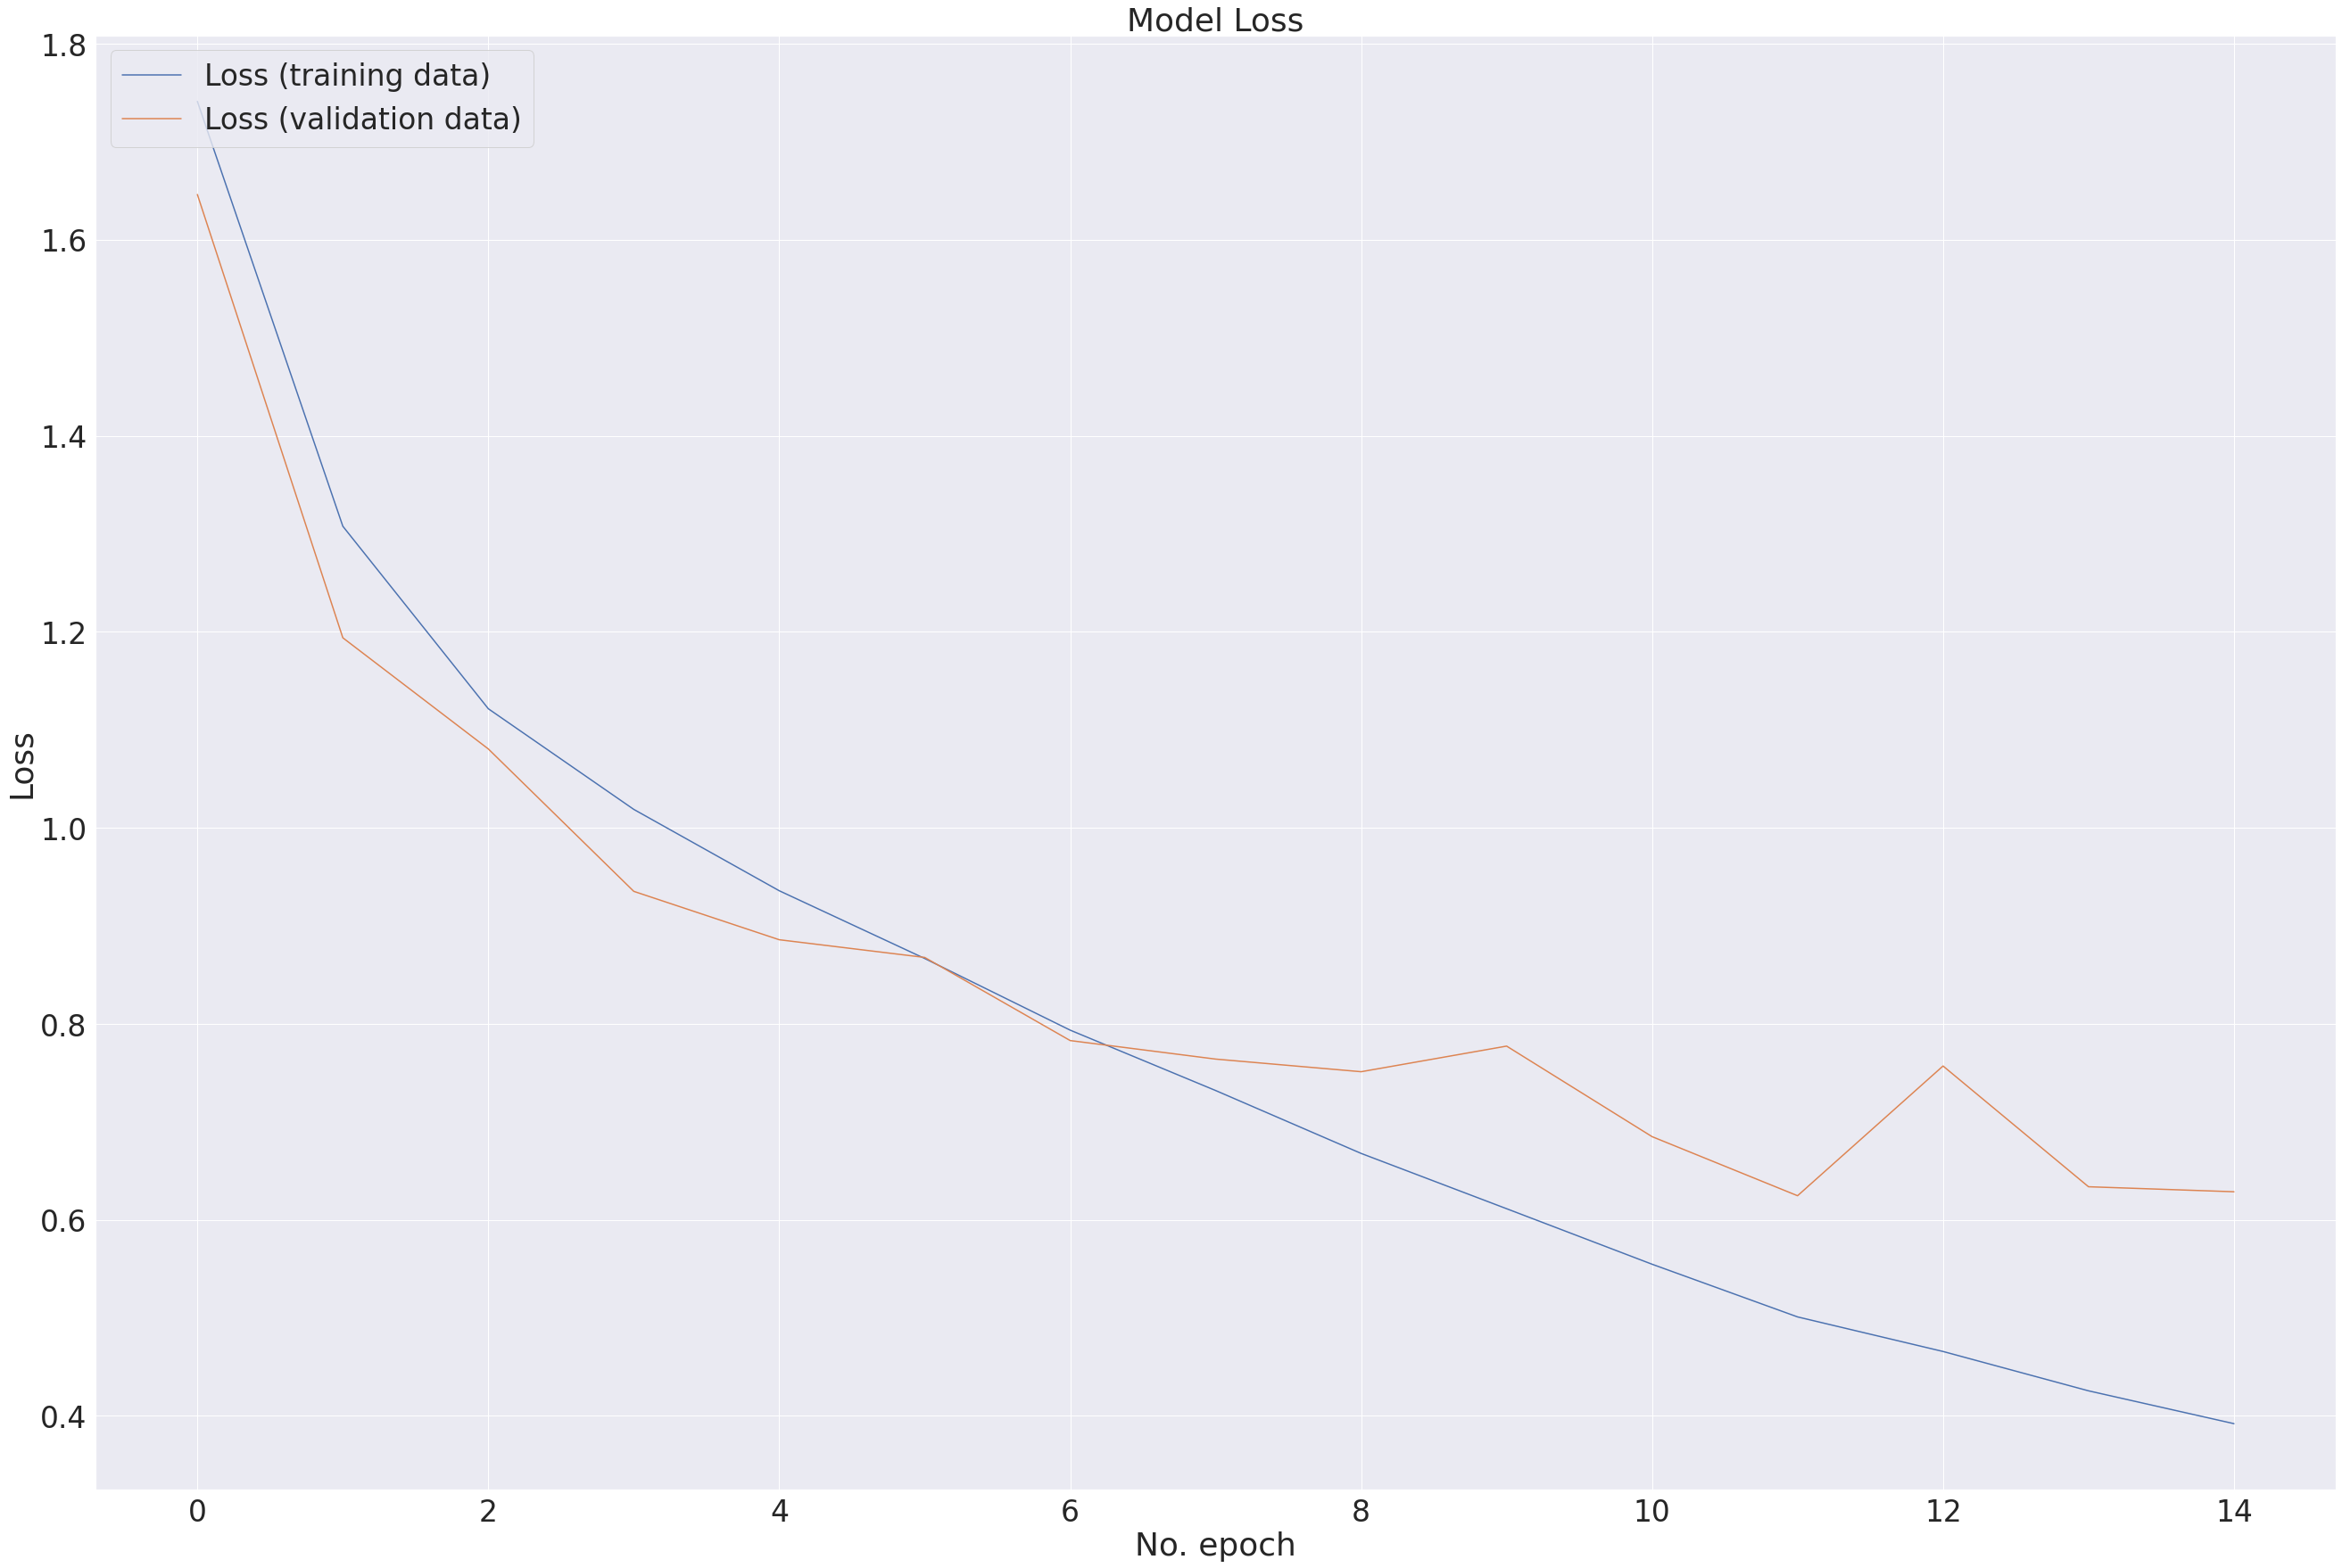

In [ ]:
# Plot history: Accuracy
plt.figure(figsize=(45,30))
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
#Calculate precision and recall for model:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test_true, y_test_pred, average="micro")
print("The weighted precision is", precision)

recall = recall_score(y_test_true, y_test_pred, average="micro")
print("The weighted recall is", recall)

The weighted precision is 0.8245325605372419
The weighted recall is 0.8245325605372419


# Part 8: Try our model with our own images (Taken from random images on Google Images)


In [23]:
#Code for face detection largely after: https://www.digitalocean.com/community/tutorials/how-to-detect-and-extract-faces-from-an-image-with-opencv-and-python

import cv2
import sys

emotions = ["Angry", "Neutral", "Surprise", "Happy", "Sad"]

for filename in os.listdir('/content/drive/My Drive/Test_Images'):
  imagePath = '/content/drive/My Drive/Test_Images/{}'.format(filename)
  image = cv2.imread(imagePath)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
  faces = faceCascade.detectMultiScale(
      gray,
      scaleFactor=1.3,
      minNeighbors=3,
      minSize=(30, 30)
  )

  print("[INFO] Found {0} Faces.".format(len(faces)))

  for (x, y, w, h) in faces:
      cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
      roi_color = image[y:y + h, x:x + w]
      print(roi_color.shape)
      print("[INFO] Object found. Saving locally.")
      cv2.imwrite('/content/drive/My Drive/cropped_images/' + str(w) + str(h) + '_faces.jpg', roi_color)

  status = cv2.imwrite('/content/drive/My Drive/cropped_images/faces_detected.jpg', image)
  print("[INFO] Image faces_detected.jpg written to filesystem: ", status)

[INFO] Found 0 Faces.
[INFO] Image faces_detected.jpg written to filesystem:  True
[INFO] Found 1 Faces.
(418, 418, 3)
[INFO] Object found. Saving locally.
[INFO] Image faces_detected.jpg written to filesystem:  True
[INFO] Found 0 Faces.
[INFO] Image faces_detected.jpg written to filesystem:  True
[INFO] Found 1 Faces.
(445, 445, 3)
[INFO] Object found. Saving locally.
[INFO] Image faces_detected.jpg written to filesystem:  True
[INFO] Found 1 Faces.
(151, 151, 3)
[INFO] Object found. Saving locally.
[INFO] Image faces_detected.jpg written to filesystem:  True
[INFO] Found 1 Faces.
(86, 86, 3)
[INFO] Object found. Saving locally.
[INFO] Image faces_detected.jpg written to filesystem:  True
[INFO] Found 1 Faces.
(90, 90, 3)
[INFO] Object found. Saving locally.
[INFO] Image faces_detected.jpg written to filesystem:  True
[INFO] Found 0 Faces.
[INFO] Image faces_detected.jpg written to filesystem:  True
[INFO] Found 1 Faces.
(110, 110, 3)
[INFO] Object found. Saving locally.
[INFO] Image

In [5]:
#Crops an image to a square
def crop_center(pil_img, crop_width, crop_height):
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

Model-generated label:
Happy


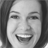


Model-generated label:
Sad


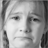


Model-generated label:
Angry


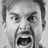


Model-generated label:
Happy


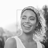


Model-generated label:
Sad


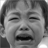


Model-generated label:
Sad


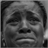


Model-generated label:
Surprise


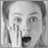


Model-generated label:
Surprise


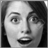


Model-generated label:
Angry


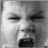


Model-generated label:
Angry


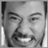


Model-generated label:
Angry


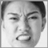


Model-generated label:
Sad


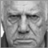


Model-generated label:
Neutral


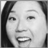


Model-generated label:
Happy


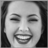


Model-generated label:
Angry


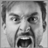


Model-generated label:
Angry


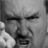


Model-generated label:
Angry


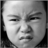


Model-generated label:
Angry


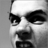


Model-generated label:
Surprise


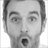


Model-generated label:
Happy


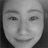


Model-generated label:
Sad


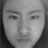


Model-generated label:
Surprise


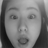


Model-generated label:
Sad


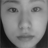


Model-generated label:
Happy


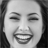


Model-generated label:
Happy


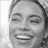

In [25]:
emotions = ["Angry", "Neutral", "Surprise", "Happy", "Sad"]

for filename in os.listdir('/content/drive/My Drive/cropped_images'):
  image = Image.open('/content/drive/My Drive/cropped_images/{}'.format(filename))
  image = crop_center(image, min(image.width, image.height), min(image.width, image.height))
  new_image = image.resize((48, 48))
  grey  = new_image.convert('L')
  new_image_array = np.array(grey)
  new_image_array = new_image_array[np.newaxis, ..., np.newaxis]

  print("Model-generated label:")
  prediction = reconstructed_model.predict(new_image_array)
  y_classes = prediction.argmax(axis=-1)
  y_classes = y_classes.reshape((1,-1))
  y_classes = int(y_classes[0])
  print(emotions[y_classes])
  new_image_array = new_image_array.astype(np.uint8)
  new_image_array = new_image_array.reshape(48, 48)
  display(Image.fromarray(new_image_array))
  print("")